In [7]:
from models.lstm_ad import LSTM_AD
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score
from utils.data import create_sequences

from ipywidgets import IntProgress
from IPython.display import display

In [10]:
class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 2
    batch_size = 32
    Q = 0.99

In [49]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.33458,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.07851,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0


In [53]:
SS = StandardScaler()
x_train = np.array(SS.fit_transform(df[:train_size].drop(['anomaly','changepoint'], axis=1)))
x_train = create_sequences(x_train, Config.TIME_STEPS)

In [54]:
lstm_ad = LSTM_AD().fit(x_train)

Epoch 1/2
11/11 [==============================] - 6s 133ms/step - loss: 0.8948
Epoch 2/2
11/11 [==============================] - 2s 143ms/step - loss: 0.7867


In [56]:
x_test = np.array(SS.transform(df.drop(['anomaly','changepoint'], axis=1)))
x_test = create_sequences(x_test, Config.TIME_STEPS)

In [57]:
predictions = lstm_ad.predict(x_test)

In [62]:
r = pd.Series(np.sum(np.mean(np.abs(np.array(predictions) - x_test), axis=1), axis=1))
health_r = r[:train_size]

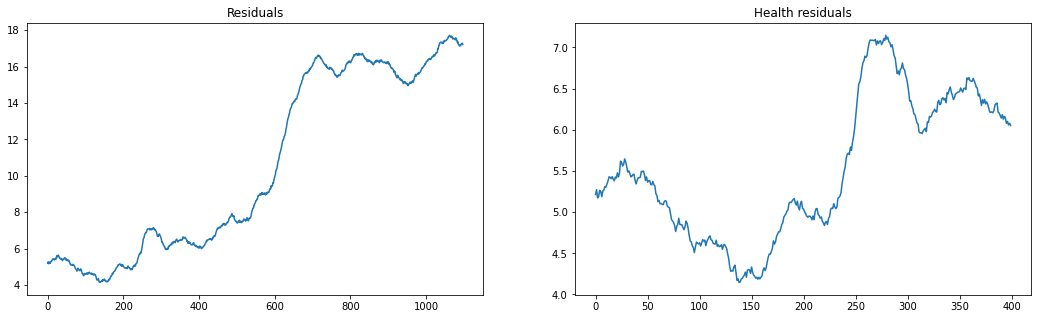

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].plot(r)
axes[0].set_title("Residuals")
axes[1].plot(health_r)
axes[1].set_title("Health residuals")
plt.show()

In [67]:
UCL = health_r.quantile(Config.Q)
anomalous_data = r > (3/2 * UCL)

anomalous_data_indices = [] 
for data_idx in range(TIME_STEPS - 1, len(x_test) - TIME_STEPS + 1):
    if np.all(anomalous_data[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx - int(TIME_STEPS // 6))

prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1

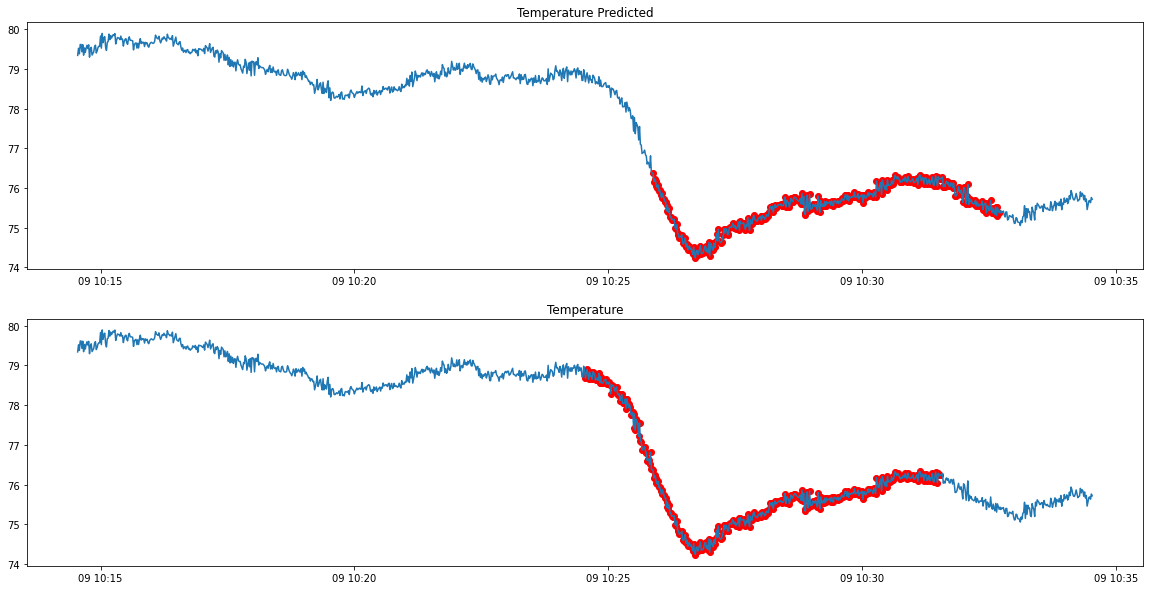

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(df.anomaly)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [69]:
print(f"""F1 = {f1_score(df.anomaly, prediction)}
FAR = {far(df.anomaly, prediction)}
MAR = {mar(df.anomaly, prediction)}""")

F1 = 0.819672131147541
FAR = 0.08981233243967829
MAR = 0.18952618453865336


### Применение метода ко всем датасетам

In [4]:
from utils.pipeline import Pipeline, Predictor

In [14]:
class LSTM_AD_Predictor(Predictor):
    def make_prediction(self, df):
        
        SS = StandardScaler()
        df = df.drop(['anomaly','changepoint'], axis=1)
             
        x_train = np.array(SS.fit_transform(df[:Config.train_size]))
        x_train = create_sequences(x_train, Config.TIME_STEPS)

        lstm_ad = LSTM_AD().fit(x_train)
        x_test = np.array(SS.transform(df))
        x_test = create_sequences(x_test, Config.TIME_STEPS)

        predictions = lstm_ad.predict(x_test)

        r = pd.Series(np.sum(np.mean(np.abs(np.array(predictions) - x_test), axis=1), axis=1))
        health_r = r[:Config.train_size]
        
        UCL = health_r.quantile(Config.Q)
        anomalous_data = r > (3/2 * UCL)

        anomalous_data_indices = [] 
        for data_idx in range(Config.TIME_STEPS - 1, len(x_test) - Config.TIME_STEPS + 1):
            if np.all(anomalous_data[data_idx - Config.TIME_STEPS + 1 : data_idx]):
                anomalous_data_indices.append(data_idx - int(Config.TIME_STEPS // 6))

        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

Anomaly: valve11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/2
11/11 [==============================] - 6s 135ms/step - loss: 0.8856
Epoch 2/2
11/11 [==============================] - 1s 133ms/step - loss: 0.7835
F1 = 0.7909090909090909

FAR = 0.0

MAR = 0.3458646616541353



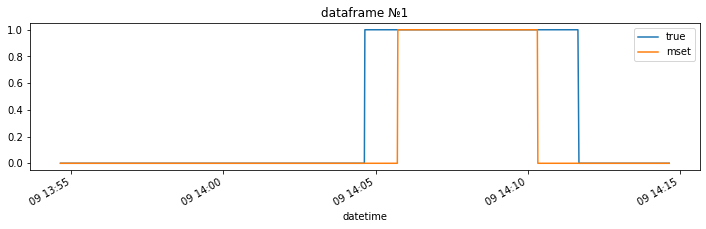

In [15]:
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

lstm_ad_predictor = LSTM_AD_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, lstm_ad_predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [16]:
from utils.data import show_score_table

In [17]:
show_score_table(metrics)

metric | valve11
--- | ---
F1 |0.79
FAR |0.0
MAR |0.35